In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import datetime as dt


import sqlite3
conn = sqlite3.connect('../Spotify_Challenge/dbsql.db')
from sqlalchemy import create_engine
disk_engine = create_engine('sqlite:///../Spotify_Challenge/dbsql.db')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
### Library
def squared_distance(v1,v2):
    """
    calculates squared euclidean distance between two points
    v1 and v2 are np array of same dimension
    """
    return sum(x**2 for x in (v2-v1))
    



def cluster_airports(yoi,K,col_names=None,inputs=[1],gen_plots=True):
    """
    yoi: year if interest
    """
    agg_scaled = inputs
    
    if len(agg_scaled) == 1:
        # put origin and destination agg tables together
        print "getting data from db"
        agg_df = pd.merge(df1[df1.YEAR == yoi],df2[df2.YEAR == yoi],left_on='ORIGIN',right_on='DEST')
        agg_df = pd.merge(agg_df,airports,left_on='ORIGIN', right_on='iata')
        agg_df.drop(['DEST','YEAR_y','iata'],axis=1,inplace=True)
        agg_df.rename(columns={'YEAR_x':'YEAR','FLIGHTS_x':'DEP_FLIGHTS','FLIGHTS_y':'ARR_FLIGHTS','ORIGIN':'IATA',
                              'lat':'LAT','long':'LON'}, inplace=True)

        # check for missing values and replace them with the most frequent value of the same column
        for c in agg_df.columns:
            if agg_df[agg_df[c].isnull()].shape[0]>0:
                ioi = agg_df[agg_df[c].isnull()].index.tolist()
                try:
                    most_freq = agg_df[c].mode()[0]
                except:
                    most_freq = 0
                for i in ioi:
                    agg_df.loc[i,c]= most_freq
        # normalize data
        agg_scaled = agg_df[agg_df.columns[2:]].copy()
        std_scaler = StandardScaler()
        agg_scaled = pd.DataFrame(std_scaler.fit_transform(agg_scaled))
        agg_scaled.columns = agg_df.columns[2:]
        uncorrelated_features = [u'SEC_DEL', u'WEA_DEL', 'LAT', 'LON']
        agg_scaled = agg_scaled[uncorrelated_features]
    
    #look at the correlation
    corr_mat = agg_scaled.corr()
    
    # start clustering
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(agg_scaled)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    agg_scaled['CLASS'] = labels
    agg_df['CLASS'] = labels
    agg_scaled = pd.concat([agg_df[['YEAR','IATA']],agg_df[['CLASS','LAT', 'LON']]],axis=1)
    # combine all clusters with count <10
    vc = agg_scaled.CLASS.value_counts()
    s_classes = vc[vc<10].index.tolist()
    agg_scaled.loc[agg_scaled[agg_scaled.CLASS.isin(s_classes)].index.tolist(),'CLASS'] = 10000
    classes = sorted(pd.unique(agg_scaled.CLASS).tolist())
    new_class = 0
    for cl in classes:
        agg_scaled.CLASS.replace(cl,new_class,inplace=True)
        new_class+=1
    
    if gen_plots:
        plt.imshow(corr_mat)
        plt.show()
        plt.hist(agg_scaled.CLASS, bins=K)
    
    return {'centroids':centroids, 'df':agg_scaled,'labels':labels,'corr_mat':corr_mat}

def re_cluster(df):
    classes = pd.unique(df.CLASS)
    vcounts = df.CLASS.value_counts
    small_classes = vcounts[vcounts<10].index.tolist()
    

### Preparing data for clustering

#### Airports


In [3]:
features = [u'index',u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK', u'AIRLINE_ID', 
            u'CARRIER', u'TAIL_NUM', u'FL_NUM', u'ORIGIN_AIRPORT_ID', u'ORIGIN', u'ORIGIN_CITY_NAME', 
            u'ORIGIN_STATE_NM', u'DEST_AIRPORT_ID', u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_NM', 
            u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15', u'TAXI_OUT', u'TAXI_IN', u'ARR_DELAY', 
            u'ARR_DELAY_NEW', u'ARR_DEL15', u'CANCELLED', u'CANCELLATION_CODE', u'DIVERTED', u'AIR_TIME', 
            u'FLIGHTS', u'DISTANCE', u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY', u'SECURITY_DELAY', 
            u'LATE_AIRCRAFT_DELAY',u'FL_DATE']
years = (2010,2011,2012,2013,2014,2015)

In [4]:
# load airports data
airports = pd.read_sql_query('select iata, lat, long from airports',disk_engine)

In [5]:
# load all data aggregated by origin
tic = dt.datetime.now()
if 'agg_per_origin' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    df1 = pd.read_sql_query("SELECT * FROM agg_per_origin",disk_engine)
    if 'index' in df1.columns:
        df1.drop('index',axis=1,inplace=True)
else:
    print "querying from raw data"
    df1 = pd.read_sql_query("SELECT YEAR, ORIGIN, SUM(FLIGHTS) AS FLIGHTS, SUM(DEP_DEL15) AS DEP_DEL, "
                            "SUM(DEP_DELAY) AS DDEL1, SUM(DEP_DELAY_NEW) AS DDEL2, SUM(CANCELLED) AS CANCELLED, "
                            "SUM(SECURITY_DELAY) AS SEC_DEL, SUM(CARRIER_DELAY) AS CAR_DEL, SUM(NAS_DELAY) AS NAS_DEL, "
                            "SUM(WEATHER_DELAY) AS WEA_DEL, SUM(LATE_AIRCRAFT_DELAY) AS LAD_DEL "
                            "FROM data "
                            "GROUP BY YEAR, ORIGIN",disk_engine)
    df1.to_sql('agg_per_origin',conn,index=False)
print dt.datetime.now()-tic

0:00:00.034265


In [6]:
# load all data aggreagated by destination
tic = dt.datetime.now()
if 'agg_per_destination' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    df2 = pd.read_sql_query("SELECT * FROM agg_per_destination",disk_engine)
    if 'index' in df2.columns:
        df2.drop('index',axis=1,inplace=True)
else:
    print "querying from raw data"
    df2 = pd.read_sql_query("SELECT YEAR, DEST, SUM(FLIGHTS) AS FLIGHTS, SUM(ARR_DEL15) AS ARR_DEL, "
                            "SUM(ARR_DELAY) AS ADEL1, SUM(ARR_DELAY_NEW) AS ADEL2, SUM(DIVERTED) AS DIVERTED "
                            "FROM data "
                            "GROUP BY YEAR, DEST",disk_engine)
    df2.to_sql('agg_per_destination',conn,index=False)
    
print dt.datetime.now()-tic

0:00:00.019353


#### Airlines


In [7]:
# load data aggregated by airline
tic = dt.datetime.now()
if 'agg_per_airline' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    df3 = pd.read_sql_query("SELECT * FROM agg_per_airline",disk_engine)
    if 'index' in df3.columns:
        df3.drop('index',axis=1,inplace=True)
else:
    df3 = pd.read_sql_query("SELECT YEAR, CARRIER, SUM(FLIGHTS) AS FLIGHTS, SUM(ARR_DEL15) AS ARR_DEL, "
                            "SUM(ARR_DELAY) AS ADEL1, SUM(ARR_DELAY_NEW) AS ADEL2, SUM(DIVERTED) AS DIVERTED, "
                            "SUM(DEP_DEL15) AS DEP_DEL, SUM(DEP_DELAY) AS DDEL1, SUM(DEP_DELAY_NEW) AS DDEL2, "
                            "SUM(CANCELLED) AS CANCELLED, SUM(SECURITY_DELAY) AS SEC_DEL, SUM(CARRIER_DELAY) AS CAR_DEL, "
                            "SUM(NAS_DELAY) AS NAS_DEL, SUM(WEATHER_DELAY) AS WEA_DEL, SUM(LATE_AIRCRAFT_DELAY) AS LAD_DEL "
                            "FROM data "
                            "GROUP BY YEAR, CARRIER",disk_engine)
    df3.to_sql('agg_per_airline',conn,index=False)
print dt.datetime.now()-tic

0:00:00.007820


In [8]:
def clusterize_airlines(data,k,col_names,gen_plots=True):
    df = data[col_names]
    # treat missing data
    df = impute_na(df)
    # rescale data
    df = rescale_data(df)['data']
    # k cluster
    clusters = generate_clusters(df,k)
    data['CLASS'] = clusters['labels']
    
    if gen_plots:
        data.CLASS.hist()
        plt.show()
    return {'data':data[['YEAR','CARRIER','CLASS']],'centroids':clusters['centroids'],'labels':clusters['labels']}

def impute_na(data):
    cols = data.columns
    for col in cols:
        if data[data[col].isnull()].shape[0]>0:
            try:
                most_freq = data[col].mode()[0]
            except:
                most_freq = 0
            data.loc[data[data[col].isnull()].index.tolist(),col] = most_freq
    return data

def rescale_data(data):
    cols = data.columns
    s = StandardScaler()
    data = s.fit_transform(data)
    data = pd.DataFrame(data,columns=cols)
    return {'data':data,'scaler':s}

def generate_clusters(data,k):
    km = KMeans(k)
    km.fit(data)
    centroids = km.cluster_centers_
    labels = km.labels_
    return {'centroids':centroids,'labels':labels}

def squared_clustering_errors(data,k):
    cl = clusterize_airlines(data,k,col_names=data.columns.tolist()[2:])
    centroids = cl['centroids']
    labels = cl['labels']
    assignments =map(lambda x:centroids[x],labels)
    return sum(map(lambda x,y:squared_distance(x,y),data[data.columns.tolist()[2:-1]].values,assignments ))

def optimize_k(data,ks):
    errors = []
    for k in ks:
        errors.append(squared_clustering_errors(data,k))
    plt.plot(ks,errors)
    plt.show()
    return zip(ks,errors)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


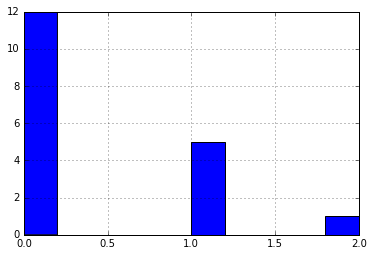

In [9]:
df = df3[df3.YEAR == 2010]
cl = clusterize_airlines(data = df,k=3,col_names=df.columns.tolist()[2:])
#df = cl['data']
#dd = optimize_k(df,range(2,4))
#df[df.columns.tolist()[2:]]#.shape

#### Flights

In [10]:
# load data aggregated by flight
tic = dt.datetime.now()
if 'agg_per_flight' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    df4 = pd.read_sql_query("SELECT * FROM agg_per_flight",disk_engine)
    if 'index' in df4.columns:
        df4.drop('index',axis=1,inplace=True)
else:
    df4 = pd.read_sql_query("SELECT YEAR, ORIGIN, DEST, SUM(FLIGHTS) AS FLIGHTS, SUM(ARR_DEL15) AS ARR_DEL, "
                            "SUM(DISTANCE) AS DISTANCE, SUM(AIR_TIME) AS AIR_TIME, "
                            "SUM(ARR_DELAY) AS ADEL1, SUM(ARR_DELAY_NEW) AS ADEL2, SUM(DIVERTED) AS DIVERTED, "
                            "SUM(DEP_DEL15) AS DEP_DEL, SUM(DEP_DELAY) AS DDEL1, SUM(DEP_DELAY_NEW) AS DDEL2, "
                            "SUM(CANCELLED) AS CANCELLED, SUM(SECURITY_DELAY) AS SEC_DEL, SUM(CARRIER_DELAY) AS CAR_DEL, "
                            "SUM(NAS_DELAY) AS NAS_DEL, SUM(WEATHER_DELAY) AS WEA_DEL, SUM(LATE_AIRCRAFT_DELAY) AS LAD_DEL "
                            "FROM data "
                            "GROUP BY YEAR, ORIGIN, DEST",disk_engine)
    df4.to_sql('agg_per_flight',conn,index=False)
print dt.datetime.now()-tic

0:00:00.349386


In [425]:
def clusterize_flights(data,k,col_names,gen_plots=True):
    df = data[col_names]
    # treat missing data
    df = impute_na(df)
    # rescale data
    df = rescale_data(df)['data']
    # k cluster
    clusters = generate_clusters(df,k)
    data['CLASS'] = clusters['labels']
    
    if gen_plots:
        data.CLASS.hist()
        plt.show()
    return {'data':data[['YEAR','ORIGIN','DEST','CLASS']],'centroids':clusters['centroids'],'labels':clusters['labels']}

### Cluster analysis

#### Airport

getting data from db


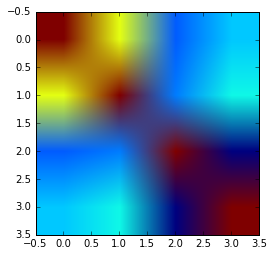

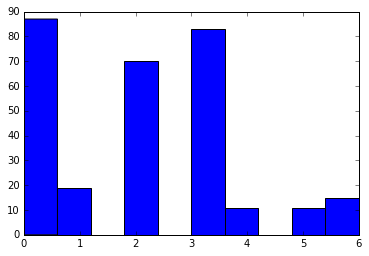

In [294]:
clst = cluster_airports(yoi=2011,K=10)
corr_mat = clst['corr_mat']

In [433]:
#### Flights

In [303]:
#droplist = ['DEP_FLIGHTS','DEP_DEL','DDEL1','DDEL2','CANCELLED','CAR_DEL',
#            'NAS_DEL','ADEL1','ADEL2','LAD_DEL','DIVERTED','ARR_DEL','ARR_FLIGHTS']#,'SEC_DEL','WEA_DEL']
#print corr_mat.drop(droplist,axis=0).drop(droplist,axis=1)
#uncorrelated_features = corr_mat.drop(droplist,axis=0).drop(droplist,axis=1).columns.tolist()
#inputs = clst['df'][uncorrelated_features]
#clst = cluster_airports(yoi=2011,K=10)

airports_cluster = pd.DataFrame()
for year in years:
    print year
    clst = cluster_airports(yoi=year,K=10,gen_plots=False)
    airports_cluster = pd.concat([airports_cluster,clst['df']],ignore_index=True)
try:
    airports_cluster.to_sql('airports_cluster',conn,index=False)
except:
    pass
print conn.execute("select name from sqlite_master where type = 'table'").fetchall()

2010
getting data from db
2011
getting data from db
2012
getting data from db
2013
getting data from db
2014
getting data from db
2015
getting data from db
[(u'data',), (u'airports',), (u'carriers',), (u'flights',), (u'agg_per_origin',), (u'agg_per_destination',), (u'airports_cluster',)]


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


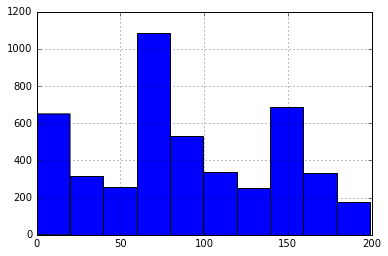

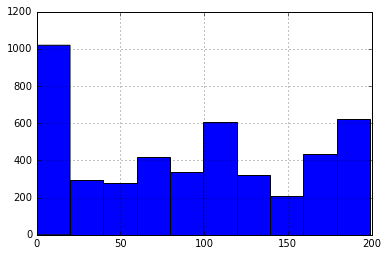

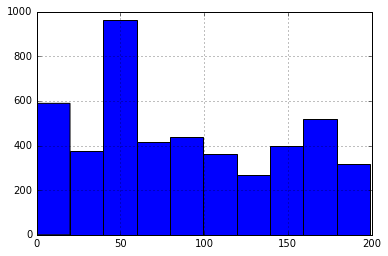

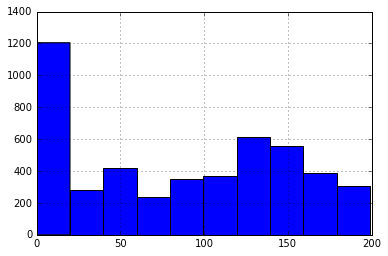

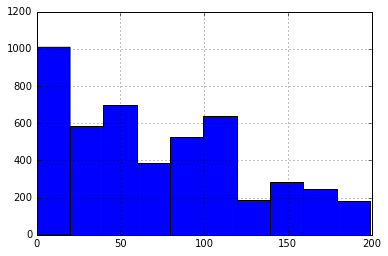

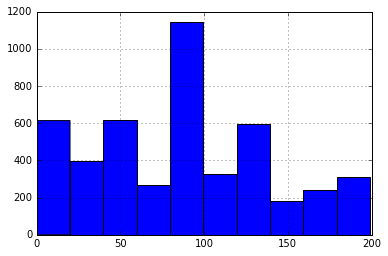

[(u'data',), (u'airports',), (u'carriers',), (u'flights',), (u'agg_per_origin',), (u'agg_per_destination',), (u'airports_cluster',), (u'agg_per_airline',), (u'agg_per_flight',), (u'flight_cluster',)]


In [432]:
#df = clusterize_flights(df4[df4.YEAR==2010],k=200,col_names=df4.columns[3:])
flight_cluster = pd.DataFrame()
for year in years:
    df = df4[df4.YEAR == year]
    df = clusterize_flights(df,k=200,col_names=df.columns[3:])
    flight_cluster = pd.concat([flight_cluster,df['data']], ignore_index=True,gen_plots=False)
flight_cluster.to_sql('flight_cluster',conn,index=False)
try:
    print conn.execute("select name from sqlite_master where type = 'table'").fetchall()
except:
    pass

In [8]:
type('cscs') is str

True